### Evictions data:

We first read in the original dataset from the Evictions Lab, limit it to only block groups within Cook County (we will later limit this to Chicago), and construct a census tract ID to facilitate future joining to the ACS data.

In [1]:
import pandas as pd
import numpy as np

In [2]:
block_groups = pd.read_csv('raw_data/block-groups.csv',
                           dtype={'GEOID': str})

#Restricting evictions data to Cook County
evictions = block_groups[block_groups['parent-location'] == 'Cook County, Illinois'].copy()

#Creating a census tract ID by removing the block group signifier 
evictions['tract_id'] = evictions['GEOID'].apply(lambda x: x[:-1])

### Cleaning Cook County Crime Data:

We now use the City of Chicago data portal API to download crime data for Chicago.

In [3]:
from sodapy import Socrata
import datetime as dt

In [4]:
'''
Reading in selected columns from the Chicago Data Portal
between 2001-present
'''
crime = pd.read_csv('raw_data/Crimes_-_2001_to_present.csv',
                    usecols=['Date', 'Primary Type', 'Description', 'Community Area', 'Zip Codes', 'Location'],
                    dtype={'Community Area': str},
                    parse_dates=['Date'], date_parser = pd.to_datetime)

#Subsetting data to match our evictions timeframe
crime = crime[crime.Date < '01/01/2017']

#removing 57,388 row missing Location data that we would be unable to
#merge with ACS and therefore eviction data
crime = crime[~crime.Location.isnull()]

In [5]:
'''
In order to better interpret our data, we rename 'community area' codes
to their respective neighborhood names.
'''

#Interacting with API to get community area to neighborhood conversions
client = Socrata("data.cityofchicago.org", None)
neighborhoods = client.get("igwz-8jzy", select="AREA_NUMBE, COMMUNITY")

#Creating dictionary mapping community area to neighborhood
neighborhood_dict = pd.DataFrame.from_records(neighborhoods, index="AREA_NUMBE").to_dict()["COMMUNITY"]

#Note that we name area '0' as 'OHARE' as O'Hare was not listed in the data portal
neighborhood_dict['0'] = "OHARE"

#Renaming to neighborhoods
crime['Community Area'] = crime['Community Area'].replace(neighborhood_dict)

### Cleaning ACS Demographic Data:

We now obtain certain demographic variables (American Community Survey estimates) through the census API.

In [6]:
from census import Census
from functools import reduce

In [7]:
acs_key = "1006a1e4567f2582e57c3affbab639c19c930271"
acs_bgs = []
acs_tracts = []

for time in range(2010,2017):
    acs = Census(acs_key, year=time)

    '''
    Due to changes in ACS data over the years, the following variables were
    unavailable for download before 2013
    '''
    if time >= 2013:
        req_bg = acs.acs5.get(('NAME', 'B25010_002E', 'B25010_003E'), 
                              {'for': 'block group:*', 'in': 'state:17 county:031'})
        
        block_groups = pd.DataFrame(req_bg)
        block_groups = block_groups.rename(columns={
                            "B25010_002E": "avg_household_size_owner",
                            "B25010_003E": "avg_household_size_renter"})
        
        #Creating a column for year an ACS variable pulled from
        block_groups['year'] = time
        acs_bgs.append(block_groups)
    
    #Note that these variables are census tract level
    req_tracts = acs.acs5.get(('NAME','B06009_002E', 'B06009_003E', 'B06009_004E',
                           'B06009_005E', 'B23020_001E'), 
                       {'for': 'tract:*', 'in': 'state:17 county:031'})

    tracts = pd.DataFrame(req_tracts)
    tracts = tracts.rename(columns={
                            "B06009_002E": "Total_Less_Than_HS",
                            "B06009_003E": "Total_HS_Grad",
                            'B06009_004E': 'Total_Some_College_or_AAS',
                            'B06009_005E': 'Total_Bachelors',
                            'B23020_001E': 'Mean_hours_worked'})
    tracts['year'] = time
    acs_tracts.append(tracts)
    
tracts_df = pd.concat(acs_tracts)
bg_df = pd.concat(acs_bgs)


#Create a unique id to identify each block group or tract
bg_df['bgid'] = (bg_df.state + bg_df.county
                        + bg_df.tract + bg_df['block group'])

tracts_df['tract_id'] = (tracts_df.state + tracts_df.county
                        + tracts_df.tract)

'''
Set 234 negative values from 'avg_household_size_owner' and
1,125 negative values from 'avg_household_size_renter' to NaN
'''
for col in bg_df.columns[:2]:
    bg_df.loc[bg_df[col] < 0, col] = np.nan

#Set 32 negative values from 'Mean_hours_worked' to NaN
for col in tracts_df.columns[:5]:
    tracts_df.loc[tracts_df[col] < 0, col] = np.nan
    
#Fill NaNs with preceding value
bg_df.fillna(method='ffill', inplace=True)
tracts_df.fillna(method='ffill', inplace=True)

#Remove extraneous columns from bg_df and tracts_df
bg_df = bg_df.drop(['NAME', 'block group', 'county', 'state', 'tract'], axis=1)
tracts_df = tracts_df.drop(['NAME', 'county', 'state', 'tract'], axis=1)

We now have two separate dataframes containing ACS data between 2009-2016 at the Census Tract level and ACS data between 2013-2016 at the block group level. We wish to impute values so our ACS data will match the size of our Evictions data. After investigating several of our ACS variables, we decided that calculating time trends through regression analysis would not be useful as the small number of data points caused unrepresentative patterns. However, it is not sufficient to simply impute the median or mean value for time series data. Thus, we calculate the percent change in population between block groups over time from our Eviction dataframe as a proxy for assumed change in ACS variables.

We impute at this point (before carrying out train/test splits) because our imputation is carried out based on the time trend within that particular block group, i.e. extrapolating backwards from future data - the very nature of our imputation method makes it impossible to carry out without the full set of available data from the future. In addition, since we are only looking at future values within that specific block group, it does not matter that we have not yet filtered our dataset to only contain block groups within the city of Chicago (rather than Cook County as a whole) - there is no leakage of information from other block groups, again because our imputation method is solely concerned with the time trend within that single block group.

In [8]:
def create_impute_dict(data, group_id):
    '''
    Create a dictionary of dictionaries
    for a given dataframe
    '''
    pct_changes = data.groupby([group_id, 'year']).population.sum().pct_change().reset_index()
    
    '''
    Setting pct_change to NaN in the year 2000, so there is no
    change found between GEOID groups
    '''
    pct_changes.loc[pct_changes['year'] == 2000, 'population'] = np.nan
    
    return pct_changes.groupby(group_id).apply(lambda x: dict(zip(x['year'], x['population']))).to_dict()

In [9]:
def impute_data(data, cols, year, impute_dict):
    '''
    Impute previous years of data using population change
    as a proxy for other variables.
    
    Iteratively creates a new dataframe with a given list of columns
    
    Inputs:
        data (dataframe)
        cols (list of columns)
        year (int)
        impute_dict (dictionary)
    
    Returns:
        a dataframe
    '''
    df = pd.DataFrame(columns=cols)
    
    i = 0
    for name, group in data.groupby(cols[-1]):
        if name in impute_dict:
            curr = group[group['year'] == year][cols[0]].squeeze()
            prev = curr
            for time in range(year, 2000, -1):
                scalar = (1 - impute_dict[name][time])
                df.loc[i] = [prev * scalar, time - 1, name]
                prev = prev * scalar
                i += 1
    
    return df

In [10]:
#Creating imputation dictionaries for block and tract ids 
bg_impute_dict = create_impute_dict(evictions, 'GEOID')
tract_impute_dict = create_impute_dict(evictions, 'tract_id')

In [11]:
bg_impute_list = []
for column in bg_df.columns[:2]:
    bg_impute_list.append(impute_data(bg_df, [column, 'year', 'bgid'], 2013, bg_impute_dict))
    
bg_imputes = pd.merge(bg_impute_list[0], bg_impute_list[1], on=['bgid','year'])
bg_imputes = bg_imputes[['avg_household_size_owner', 'avg_household_size_renter', 'year', 'bgid']]

bg_df = pd.concat([bg_df, bg_imputes]).sort_values(by=['bgid', 'year'])

#Adding a tract_id column for merging later
bg_df['tract_id'] = bg_df['bgid'].apply(lambda x: x[:-1])

In [12]:
tracts_impute_list = []
for column in tracts_df.columns[:5]:
    tracts_impute_list.append(impute_data(tracts_df, [column, 'year', 'tract_id'], 2010, tract_impute_dict))

tract_imputes = reduce(lambda x, y: pd.merge(x,y, on=['tract_id', 'year']), tracts_impute_list)
tract_imputes = tract_imputes[['Total_Less_Than_HS', 'Total_HS_Grad', 'Total_Some_College_or_AAS',
                               'Total_Bachelors', 'Mean_hours_worked', 'year', 'tract_id']]

tracts_df = pd.concat([tracts_df, tract_imputes]).sort_values(by=['tract_id', 'year'])

In [13]:
#Finally, we merge our ACS data into one dataframe
demographics = pd.merge(bg_df, tracts_df, on=['tract_id', 'year'], how='left')

### Spatially merging Crime data:

We now aggregate data by block group to get the most common crimes and total number of crimes in each block group. We accomplish this through a spatial join.

In [14]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [15]:
def split_location(location):
    '''
    Takes the 'Location' column from the Crime dataset
    and turns it into Point objects with corresponding
    Longitude and Latitude 
    '''
    lat, long = location.split(',')

    return Point(float(long[:-1]), float(lat[1:]))

In [16]:
def check_block_groups(dataframe, n=5, block_group=None):
    '''
    Identifies the top n crimes reported in a chosen set of block groups for
    comparison across time. Default call will return top 5 crimes for all block groups
    in all years.
    
    Inputs:
        dataframe
        n (int): desired top n crimes
        block_group (list): list of block_groups to report

    Returns:
        series - top n crimes for specified block groups
    '''
    areas = dataframe.groupby(["GEOID", dataframe.Date.dt.year, "Primary Type"])['Primary Type'].count()
    groups = areas.groupby(["GEOID","Date"]).nlargest(n).reset_index(level=[1,2], drop=True)
    
    if block_group:
        return groups[neighborhood]
    
    return groups

In [17]:
#Reading in the shapefile for block groups in Chicago
block_group_shapes = gpd.read_file("raw_data/cb_2017_17_bg_500k/cb_2017_17_bg_500k.shp")

#Creating a new geometry column of Point objects
crime['geometry'] = crime.Location.apply(lambda x: split_location(x))

#Creating a geospatial dataframe
crime_geo = gpd.GeoDataFrame(crime, geometry='geometry')

#Adjusting the coordinate reference system to match the shapefile
crime_geo.crs = {'init': 'epsg:4269'}

#Spatially joining
spcrime = gpd.sjoin(crime_geo, block_group_shapes, how='left', op='intersects')

In [18]:
#Determine top crime in a block group
top_crime = pd.DataFrame(check_block_groups(spcrime, 1))
top_crime.rename(columns={'Primary Type': 'Count'}, level=0, inplace=True)
top_crime.reset_index(inplace=True)
top_crime = top_crime[['GEOID', 'Date', 'Primary Type']]

#Determine the total amount of crimes in a block group
crime_sums = pd.DataFrame(spcrime.groupby(["GEOID", spcrime.Date.dt.year, "Primary Type"])['Primary Type'].count())
crime_sums.rename(columns={'Primary Type': 'Sum'}, inplace=True)
crime_sums = crime_sums.groupby(['GEOID', 'Date']).sum().reset_index()

#Merge top_crime and crime_sums into one dataframe
crime_aggregates = pd.merge(top_crime, crime_sums, on=['GEOID', 'Date'])

### Imputing Crime Data for 2000:

Since we lack crime data for 2000, we impute it using regression imputation. Again, since we are looking at the time trend within block groups, the imputation can occur at this stage.

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [20]:
def get_most_recent(data, name, col):
    '''
    Returns the most recent information for a given
    column, in the even that particular years are missing
    
    Inputs:
        data (dataframe)
        name (str): a GEOID
        col (str): desired column
    
    Returns:
        str or int, depending on column
        np.nan if no values match
    '''
    for year in range(2001, 2017):
        recent = data[(data['GEOID'] == name) &
                      (data.Date == year)][col].squeeze()

        if not isinstance(recent, pd.Series):
            return recent

    return np.nan

In [21]:
def impute_crime(dataframe, cols, time_trends, year):
    '''
    Creates a datframe with the predicted value for Sums and
    most recent value for primary crime type. Iterates over
    different time series trends and chooses the regression
    model with the highest adjusted r-squared term for prediction.
    
    Inputs:
        dataframe
        cols (list)
        time_trends (list)
        year (int)
    
    Returns:
        dataframe
    '''
    df = pd.DataFrame(columns=cols)

    i = 0
    for name, group in dataframe.groupby('GEOID'):
        evals = []
        models = []
        for time in time_trends:
            model = smf.ols(formula='Sum ~ ' + time,
                            data = dataframe[dataframe['GEOID'] == name]).fit()
            evals.append(model.rsquared_adj)
            models.append(model)
        impute = models[evals.index(max(evals))].predict(exog=dict(Date=year))
        impute = impute.squeeze()
        
        #Imputes most recent 'Sum' for the 4 cases where negative values
        #were predicted due to overfitting
        if impute <= 0:
            impute = get_most_recent(crime_aggregates, name, 'Sum')
        p_type = get_most_recent(crime_aggregates, name, 'Primary Type')
        df.loc[i] = [name, year, p_type, impute]
        i += 1
    return df

In [22]:
'''
We found iterating over linear and quadratic
time trends was more effective than including higher
order polynomial terms, which tended to overfit the 
data and often predicted negative crime values
'''
time_trends = ['Date', 'Date + np.power(Date, 2)']

#Imputing data for 2001
crime_imputes = impute_crime(crime_aggregates, ['GEOID', 'Date', 'Primary Type', 'Sum'], time_trends, 2000 )

full_crime = pd.concat([crime_aggregates, crime_imputes]).sort_values(by=['GEOID', 'Date'])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1549: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1550: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1549: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)


### Merging crime, demographics, and eviction data:

We merge our evictions, ACS (demographic), and crime data into a single dataframe.

In [23]:
#Renaming demographics columns for merge
demographics.rename(columns={'bgid':'GEOID', 'year': 'Date'}, inplace=True)
evictions.rename(columns={'year': 'Date'}, inplace=True)

#Merging demographics and crime dataframes
acs_crime = pd.merge(demographics, full_crime, on=['GEOID', 'Date'], how='left')

#Casting types to match evictions dataframe
acs_crime['Date'] = acs_crime['Date'].astype(int)

#Merging evictions and ACS/Crime dataframes
evictions = pd.merge(evictions, acs_crime, on=['GEOID', 'Date'], how='inner')

### Cleaning and merging redlining data:

In [28]:
#Ensuring block group shapefile is ready for spatial join
block_group_shapes['geometry'] = block_group_shapes['geometry'].apply(Polygon)

#Reading in redlining data
holc = gpd.read_file('raw_data/HOLC_Chicago.shp')

holc.crs = {'init': 'epsg:4269'}

#By joining the block groups shapefile to the redlining shapefile,
#we find which block groups are located in redlined areas.
intersections = gpd.sjoin(block_group_shapes, holc, how="left", op="intersects")

'''
Since 50% of Chicago was classified as C ("Definitely Declining") by
the Home Owners' Loan Corporation, we define a "redlined" area as
one classified as D ("Hazardous") by the HOLC.
'''
intersections['redlined'] = np.where(intersections['holc_grade'] == 'D', 1, 0)

#Finding redlined block groups
redlined = intersections[intersections['redlined'] == 1].copy()

#Restructuring dataframe for merge
redlined_fin = redlined.drop_duplicates(['GEOID'])
redlined_fin = redlined_fin[["GEOID", "redlined", "holc_grade", "holc_id"]]

#Merging combined evictions dataframe and redlining data
evictions_with_red = pd.merge(evictions, redlined_fin, on='GEOID', how='left')

#Labeling non-redlined block groups with 0
evictions_with_red['redlined'] = evictions_with_red['redlined'].fillna(0)

### Restricting scope of data to within the city of Chicago:

In [31]:
'''
We download a dataset listing all census blocks within the city of Chicago, from 
https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Blocks-2010/mfzt-js4n
'''
chicago_blocks = pd.read_csv("raw_data/chicago_blocks.csv", dtype=str)

'''
Since the block group ID is not in the City of Chicago dataset, we construct it
from: state ID, county ID, census tract ID, and the first digit of the census block ID.
'''
chicago_blocks['GEOID'] = (chicago_blocks["STATEFP10"] + chicago_blocks["COUNTYFP10"] +
                           chicago_blocks["TRACTCE10"] + chicago_blocks["BLOCKCE10"].str[0])

chicago_blocks.drop_duplicates(['GEOID'], inplace=True)

#Final merge to restrict the domain of our data to the city of Chicago
full_data_chicago = pd.merge(evictions_with_red, chicago_blocks[['GEOID']],
                             on='GEOID', how='inner')

#Writing results to csv
full_data_chicago.to_csv('output_files/full_data_chicago.csv', index=False)

In [37]:
x = full_data_chicago.copy()

In [73]:
x.columns

Index(['GEOID', 'Date', 'name', 'parent-location', 'population',
       'poverty-rate', 'renter-occupied-households', 'pct-renter-occupied',
       'median-gross-rent', 'median-household-income', 'median-property-value',
       'rent-burden', 'pct-white', 'pct-af-am', 'pct-hispanic', 'pct-am-ind',
       'pct-asian', 'pct-nh-pi', 'pct-multiple', 'pct-other',
       'eviction-filings', 'evictions', 'eviction-rate',
       'eviction-filing-rate', 'low-flag', 'imputed', 'subbed', 'tract_id_x',
       'avg_household_size_owner', 'avg_household_size_renter', 'tract_id_y',
       'Total_Less_Than_HS', 'Total_HS_Grad', 'Total_Some_College_or_AAS',
       'Total_Bachelors', 'Mean_hours_worked', 'Primary Type', 'Sum',
       'redlined', 'holc_grade', 'holc_id'],
      dtype='object')

In [89]:
len(set(x[x['Primary Type'].isnull()]['GEOID']))

15

In [90]:
x.Sum.describe()

count    37182.000000
mean       179.334667
std        178.355213
min          0.540984
25%         74.000000
50%        130.000000
75%        230.000000
max       4402.228569
Name: Sum, dtype: float64

In [84]:
x[x.GEOID == '170310619024']['population']

4318    1192.00
4319    1192.00
4320    1192.00
4321    1192.00
4322    1192.00
4323    1104.57
4324    1104.57
4325    1104.57
4326    1104.57
4327    1104.57
4328       0.00
4329       0.00
4330       0.00
4331       0.00
4332       0.00
4333       0.00
4334       0.00
Name: population, dtype: float64

In [35]:
from matplotlib import pyplot as plt

170310619024


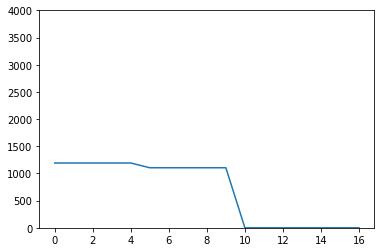

170319801001


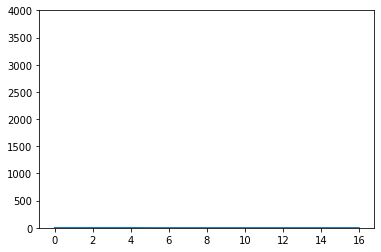

170313817001


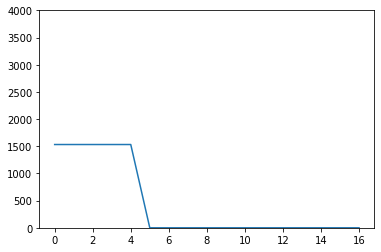

170315602002


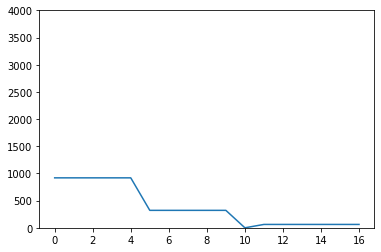

170313515001


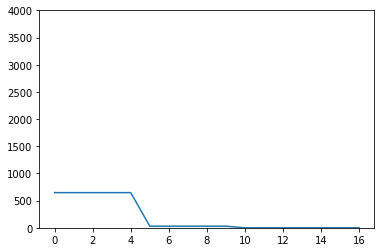

170318357001


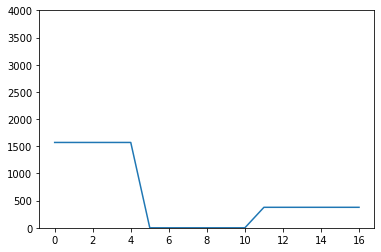

170310608002


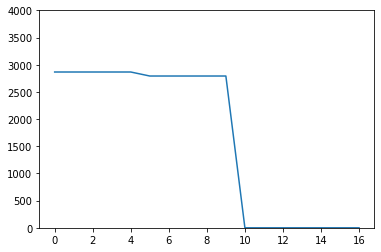

170319800001


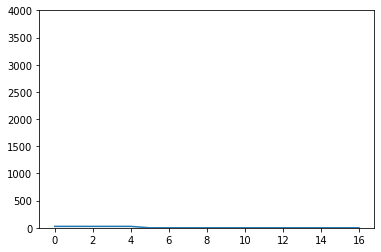

170313511003


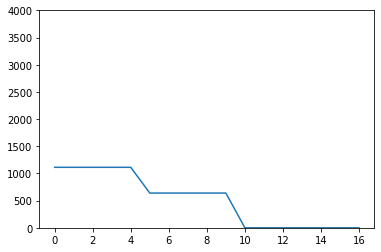

170310609002


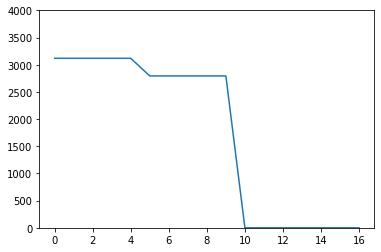

In [80]:
for g_id in set(x[x.population == 0]['GEOID']):
    plt.plot(list(x[x['GEOID'] == g_id]['population']))
    axes = plt.gca()
    axes.set_ylim([0, 4000])
    print(g_id)
    plt.show()

In [74]:
x['Total_Less_Than_HS'].describe()

count    37258.000000
mean       538.595389
std        434.620086
min       -648.157451
25%        210.993579
50%        450.000000
75%        760.000000
max       4740.000000
Name: Total_Less_Than_HS, dtype: float64

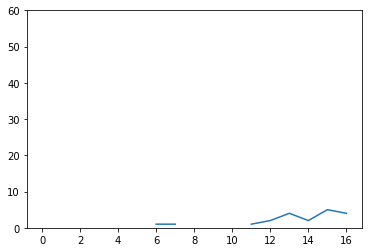

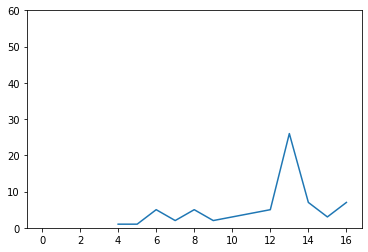

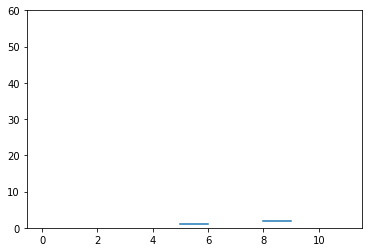

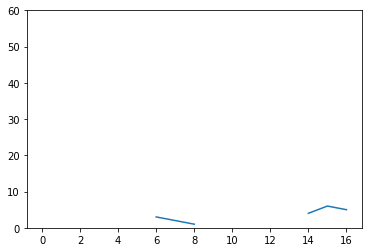

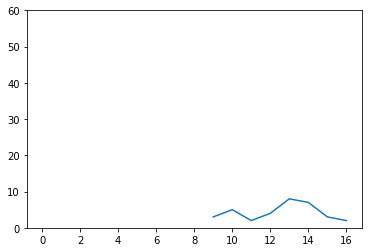

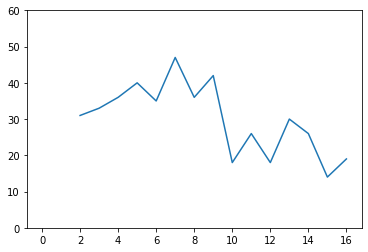

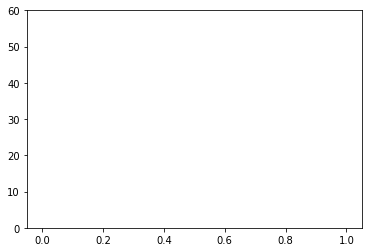

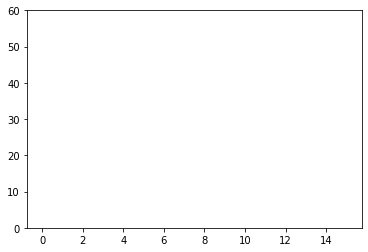

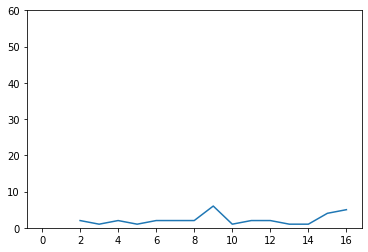

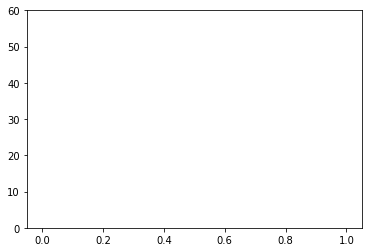

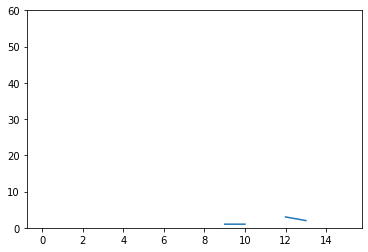

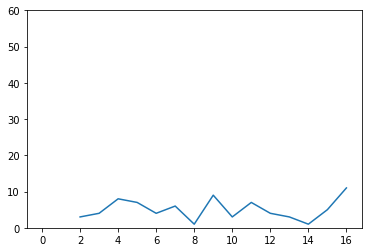

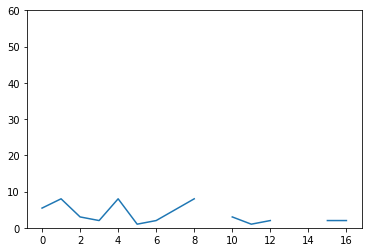

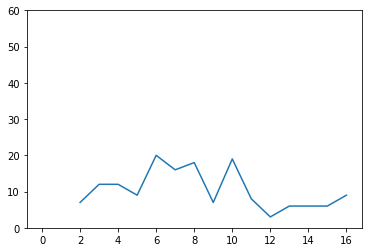

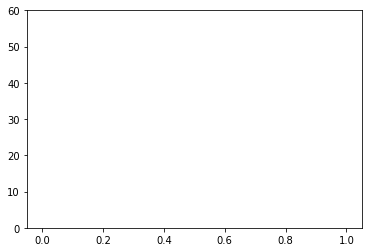

In [93]:
for g_id in set(x[x['Sum'].isnull()]['GEOID']):
    plt.plot(list(x[x['GEOID'] == g_id]['Sum']))
    axes = plt.gca()
    axes.set_ylim([0, 60])
    plt.show()

In [50]:
len(x[x['median-household-income'].isnull()]['GEOID'])

581

In [51]:
len(set(x[x['median-household-income'].isnull()]['GEOID']))

97

In [54]:
for g_id in set(x[x['median-household-income'].isnull()]['GEOID']):
    print(x[x['GEOID'] == g_id][['Date', 'median-household-income']])

       Date  median-household-income
20910  2000                  42381.0
20911  2001                  42381.0
20912  2002                  42381.0
20913  2003                  42381.0
20914  2004                  42381.0
20915  2005                  54286.0
20916  2006                  54286.0
20917  2007                  54286.0
20918  2008                  54286.0
20919  2009                  54286.0
20920  2010                  55025.0
20921  2011                      NaN
20922  2012                      NaN
20923  2013                      NaN
20924  2014                      NaN
20925  2015                      NaN
20926  2016                      NaN
       Date  median-household-income
22576  2000                  42692.0
22577  2001                  42692.0
22578  2002                  42692.0
22579  2003                  42692.0
22580  2004                  42692.0
22581  2005                  64875.0
22582  2006                  64875.0
22583  2007                  64875.0
2

34067  2016                      NaN
       Date  median-household-income
18870  2000                   7664.0
18871  2001                   7664.0
18872  2002                   7664.0
18873  2003                   7664.0
18874  2004                   7664.0
18875  2005                  76111.0
18876  2006                  76111.0
18877  2007                  76111.0
18878  2008                  76111.0
18879  2009                  76111.0
18880  2010                  15966.0
18881  2011                      NaN
18882  2012                      NaN
18883  2013                      NaN
18884  2014                      NaN
18885  2015                      NaN
18886  2016                      NaN
       Date  median-household-income
37281  2000                      0.0
37282  2001                      0.0
37283  2002                      0.0
37284  2003                      0.0
37285  2004                      0.0
37286  2005                      0.0
37287  2006                      0.0
3

       Date  median-household-income
34952  2000                 15712.84
34953  2001                 15712.84
34954  2002                 15712.84
34955  2003                 15712.84
34956  2004                 15712.84
34957  2005                 15300.83
34958  2006                 15300.83
34959  2007                 15300.83
34960  2008                 15300.83
34961  2009                 15300.83
34962  2010                 13800.00
34963  2011                      NaN
34964  2012                      NaN
34965  2013                      NaN
34966  2014                      NaN
34967  2015                      NaN
34968  2016                      NaN
      Date  median-household-income
2227  2000                  15270.0
2228  2001                  15270.0
2229  2002                  15270.0
2230  2003                  15270.0
2231  2004                  15270.0
2232  2005                  10324.0
2233  2006                  10324.0
2234  2007                  10324.0
2235  2008

       Date  median-household-income
31348  2000                  45313.0
31349  2001                  45313.0
31350  2002                  45313.0
31351  2003                  45313.0
31352  2004                  45313.0
31353  2005                  32250.0
31354  2006                  32250.0
31355  2007                  32250.0
31356  2008                  32250.0
31357  2009                  32250.0
31358  2010                  33173.0
31359  2011                      NaN
31360  2012                      NaN
31361  2013                      NaN
31362  2014                      NaN
31363  2015                      NaN
31364  2016                      NaN
       Date  median-household-income
19856  2000                  24821.0
19857  2001                  24821.0
19858  2002                  24821.0
19859  2003                  24821.0
19860  2004                  24821.0
19861  2005                  40156.0
19862  2006                  40156.0
19863  2007                  40156.0
1

      Date  median-household-income
9044  2000                  33519.0
9045  2001                  33519.0
9046  2002                  33519.0
9047  2003                  33519.0
9048  2004                  33519.0
9049  2005                  38023.0
9050  2006                  38023.0
9051  2007                  38023.0
9052  2008                  38023.0
9053  2009                  38023.0
9054  2010                  47016.0
9055  2011                      NaN
9056  2012                      NaN
9057  2013                      NaN
9058  2014                      NaN
9059  2015                      NaN
9060  2016                      NaN
       Date  median-household-income
20179  2000                  15139.0
20180  2001                  15139.0
20181  2002                  15139.0
20182  2003                  15139.0
20183  2004                  15139.0
20184  2005                  23173.0
20185  2006                  23173.0
20186  2007                  23173.0
20187  2008        